# Business Case 3

## Instacart Market Basket Analysis

#### Made by:
* Catarina Candeias (m20200656@novaims.unl.pt)
* Catarina Urbano (m20200607@novaims.unl.pt)
* Margarida Pereira (m20201038@novaims.unl.pt)
* Rita Ferreira (m20200661@novaims.unl.pt)

### Table of contents:

* [1. Business Understanding](#1)
* [2. Data Understanding](#2)
* [3. Data Preparation](#3)
* [4. Modeling and Evaluation](#4)
    * [4.1. Association Rules](#4.1)
    * [4.2. Customers Segmentation by product](#4.2)
* [5. Deployment](#5)

# 1. Business Understanding <a class="anchor" id="1"></a>

This section can be seen in detail in our report

# 2. Data Understanding <a class="anchor" id="2"></a>

#### Imports 

In [1]:
import os
from pathlib import Path
import pandas as pd
# import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
from datetime import datetime

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

sns.set_style(style='white')

import warnings
warnings.filterwarnings("always", message='',category=FutureWarning)

#to show all columns and rows when displaying a dataframe
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox
from sklearn import preprocessing
import math

import matplotlib.cm as cm 

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox
from sklearn import preprocessing
import math

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from ast import literal_eval
from sklearn.feature_extraction.text import CountVectorizer

# Defining PROJECT_ROOT
PROJECT_ROOT = Path(os.path.abspath('')).resolve().parents[0]

In [2]:
# Load data 
departments = pd.read_csv('departments.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')
orderProducts = pd.read_csv('order_products.csv')

- Users are identified by user_id in the orders.csv file. Each row of the orders.csv file represents an order made by a user. Order are identified by order_id.
- Each order of a user is characterized by an order_number which specifies when it has been made with respect to the others of the same user.
- Each order consists of a set of product each characterized by an add_to_cart_order feature representing the sequence in which they have been added to the cart in that order.

In [3]:
print(departments.info(), products.info(), orderProducts.info(), orders.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   department_id  21 non-null     int64 
 1   department     21 non-null     object
dtypes: int64(1), object(1)
memory usage: 464.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     134 non-null    int64 
 1   department_id  134 non-null    int64 
 2   product_name   134 non-null    object
dtypes: int64(2), object(1)
memory usage: 3.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2019501 entries, 0 to 2019500
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int64
 1   product_id         int64
 2   add_to_cart_order  int64
 3   reordered          int64
dtypes: in

### Visualizations

###### When Do People Generally Order?

Text(0.5, 0, 'Hour Of The Day')

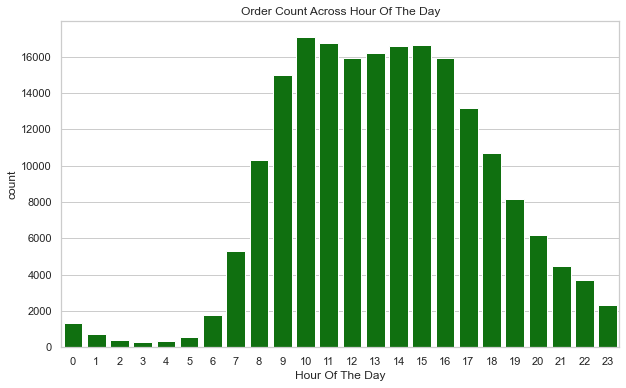

In [4]:
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
ax = sns.countplot(data=orders,x="order_hour_of_day", color='green')
plt.title("Order Count Across Hour Of The Day")
plt.xlabel('Hour Of The Day')

The majority of the orders are made during day time

###### At What Day Of The Week People Order?

Text(0.5, 0, 'Day Of The Week')

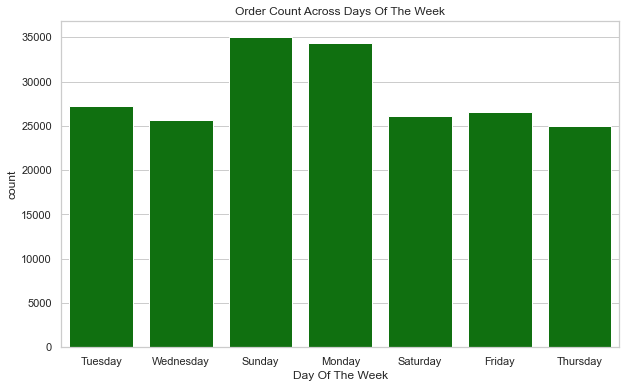

In [5]:
plt.figure(figsize=(10,6))
ordersDay = orders[["order_dow"]].replace({0:"Sunday",1:"Monday",2:"Tuesday",3:"Wednesday",4:"Thursday",5:"Friday",6:"Saturday"})
sns.countplot(data=ordersDay,x="order_dow",color='green')
plt.title("Order Count Across Days Of The Week")
plt.xlabel('Day Of The Week')

##### Best Selling Products

In [6]:
productsCount = orderProducts["product_id"].value_counts().to_frame()
productsCount["count"] = productsCount.product_id
productsCount["product_id"] = productsCount.index
mergedData = pd.merge(productsCount,products,how="left",on="product_id").sort_values(by="count",ascending=False)
mergedData.head(10)

,product_id,count,department_id,product_name
0,24,226039,4,fresh fruits
1,83,212611,4,fresh vegetables
2,123,109596,4,packaged vegetables fruits
3,120,90751,16,yogurt
4,21,61502,16,packaged cheese
5,84,55150,16,milk
6,115,52564,7,water seltzer sparkling water
7,107,45306,19,chips pretzels
8,91,39389,16,soy lactosefree
9,112,36381,3,bread


Text(0, 0.5, 'Count')

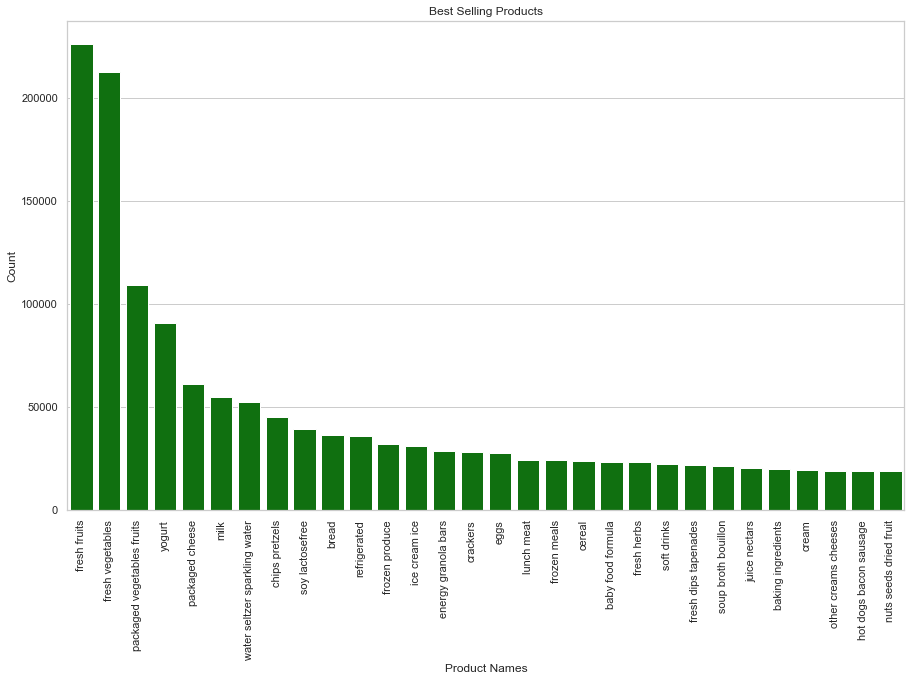

In [7]:
plt.figure(figsize=(15,9))
sns.barplot(data=mergedData.head(30),x="product_name",y="count",orient="v",color='green')
plt.xticks(rotation=90)
plt.title("Best Selling Products")
plt.xlabel('Product Names')
plt.ylabel("Count")

##### Top Reordered Products

In [8]:
productsCountReordered = orderProducts[orderProducts["reordered"]==1]["product_id"].value_counts().to_frame()
productsCountReordered["reordered_count"] = productsCountReordered.product_id
productsCountReordered["product_id"] = productsCountReordered.index
productCountReorderedMerged = pd.merge(productsCount,productsCountReordered,how="left",on="product_id").sort_values(by="count",ascending=False)
productCountReorderedMerged["reordered_ratio"] = productCountReorderedMerged["reordered_count"]/productCountReorderedMerged["count"]
productCountReorderedMerged.sort_values(by="reordered_ratio",ascending=False,inplace=True)
productMerged = pd.merge(productCountReorderedMerged,products,how="left",on="product_id")
productMerged.head(10)

,product_id,count,reordered_count,reordered_ratio,department_id,product_name
0,84,55150,43162,0.782629,16,milk
1,115,52564,38467,0.731813,7,water seltzer sparkling water
2,24,226039,162355,0.718261,4,fresh fruits
3,86,27986,19798,0.707425,16,eggs
4,91,39389,27251,0.691843,16,soy lactosefree
5,32,17408,12021,0.690545,4,packaged produce
6,53,19786,13625,0.688618,16,cream
7,120,90751,62464,0.688301,16,yogurt
8,112,36381,24540,0.674528,3,bread
9,31,35893,23854,0.664586,7,refrigerated


##### Which item do people put into the cart first?

In [9]:
productsCountFirst = orderProducts[orderProducts["add_to_cart_order"]==1]["product_id"].value_counts().to_frame()
productsCountFirst["reordered_count"] = productsCountFirst.product_id
productsCountFirst["product_id"] = productsCountFirst.index
productCountFirstMerged = pd.merge(productsCount,productsCountFirst,how="left",on="product_id").sort_values(by="count",ascending=False)
productCountFirstMerged["first_ordered_ratio"] = productCountFirstMerged["reordered_count"]/productCountFirstMerged["count"]
productCountFirstMerged.sort_values(by="first_ordered_ratio",ascending=False,inplace=True)
firstMerged = pd.merge(productCountFirstMerged,products,how="left",on="product_id")
firstMerged.head(10)

,product_id,count,reordered_count,first_ordered_ratio,department_id,product_name
0,134,614,186,0.302932,5,specialty wines champagnes
1,124,1795,519,0.289136,5,spirits
2,62,1893,424,0.223983,5,white wines
3,27,3002,659,0.219520,5,beers coolers
4,84,55150,11834,0.214578,16,milk
5,115,52564,10148,0.193060,7,water seltzer sparkling water
6,32,17408,3178,0.182560,4,packaged produce
7,28,2135,384,0.179859,5,red wines
8,77,22428,3893,0.173578,7,soft drinks
9,11,1589,257,0.161737,11,cold flu allergy


##### Do people usually reorder the same previous ordered products ?

In [10]:
grouped = orderProducts.groupby("reordered")["product_id"].aggregate(['count']).reset_index()
grouped['Ratios'] = grouped["count"].apply(lambda x: x /grouped['count'].sum())
grouped.rename(columns = {'count':'Total_products'}, inplace = True)
grouped

,reordered,Total_products,Ratios
0,0,828515,0.410257
1,1,1190986,0.589743


Approximately 59 % of ordered products are previously ordered by customers.


###### Total Orders and Reorders From Departments


In [11]:
order_products = orderProducts.merge(products, on ='product_id', how='left')
order_products = order_products.merge(departments, on ='department_id', how='left')

In [12]:
temp_df = order_products.groupby("department")["reordered"].agg(['count', 'sum']).rename(columns = {'count':'total','sum':'reorders'})
temp_df = temp_df.sort_values('total', ascending=False).reset_index()

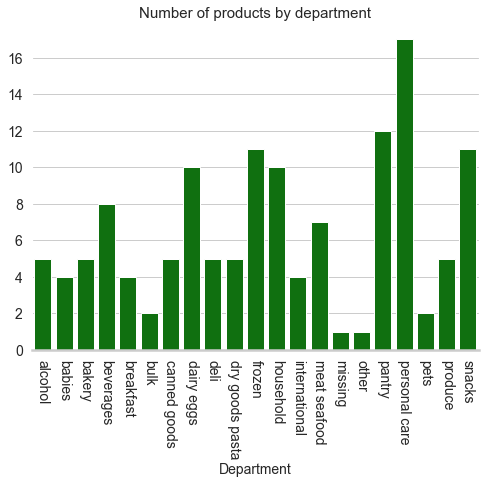

In [13]:
w = pd.merge(firstMerged, departments, on='department_id', how='left')
w = w.groupby('department')['product_id'].count().to_frame()

ig, ax = plt.subplots(figsize=(8,6))

sns.barplot(x=w.index, y=w['product_id'], ax=ax, data=w,  color='green')

ax.set_title("Number of products by department", fontdict={'fontsize':15})

ax.set_xlabel('Department', fontdict={'fontsize':14})

ax.set_ylabel('')

ax.tick_params(labelsize=14, rotation = -90)

ax.spines['bottom'].set_linewidth(2.5)

for axis in ['top', 'right', 'left']: 
    ax.spines[axis].set_color(None)

ax.tick_params(axis='y', rotation=0)

ig.show()

In [14]:
merge = pd.merge(orderProducts, products, how='left', on='product_id')
merge = pd.merge(merge, departments, how='left', on='department_id')
z = merge.groupby('department')['order_id'].count().to_frame()

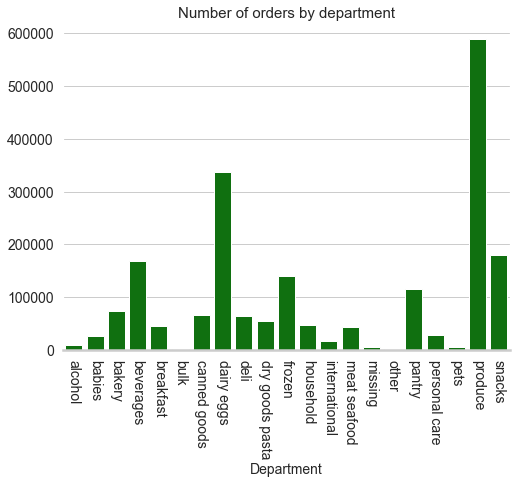

In [15]:
ig, ax = plt.subplots(figsize=(8,6))

sns.barplot(x=z.index, y=z['order_id'], ax=ax, data=z,  color='green')

ax.set_title("Number of orders by department", fontdict={'fontsize':15})

ax.set_xlabel('Department', fontdict={'fontsize':14})

ax.set_ylabel('')

ax.tick_params(labelsize=14, rotation = -90)

ax.spines['bottom'].set_linewidth(2.5)

for axis in ['top', 'right', 'left']:
    ax.spines[axis].set_color(None)

ax.tick_params(axis='y', rotation=0)

ig.show()

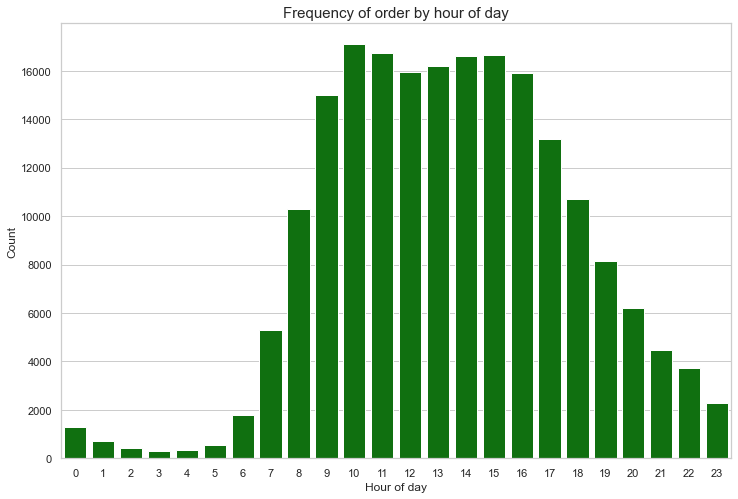

In [16]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_hour_of_day", data=orders, color='green')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.title("Frequency of order by hour of day", fontsize=15)
plt.show()

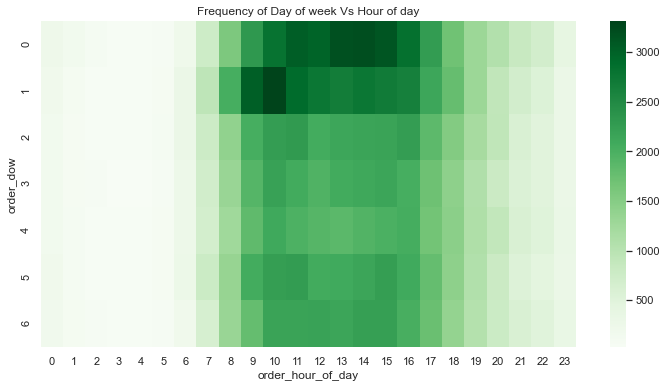

In [17]:
grouped_df = orders.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df, cmap='Greens')
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

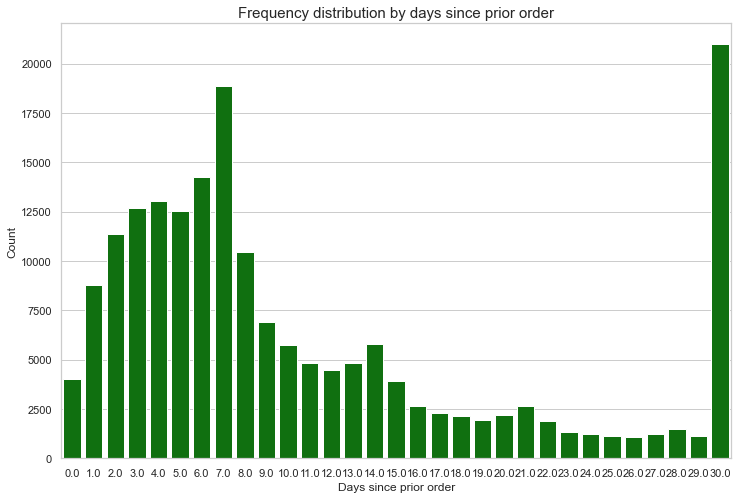

In [18]:
plt.figure(figsize=(12,8))
sns.countplot(x="days_since_prior_order", data=orders, color='green')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

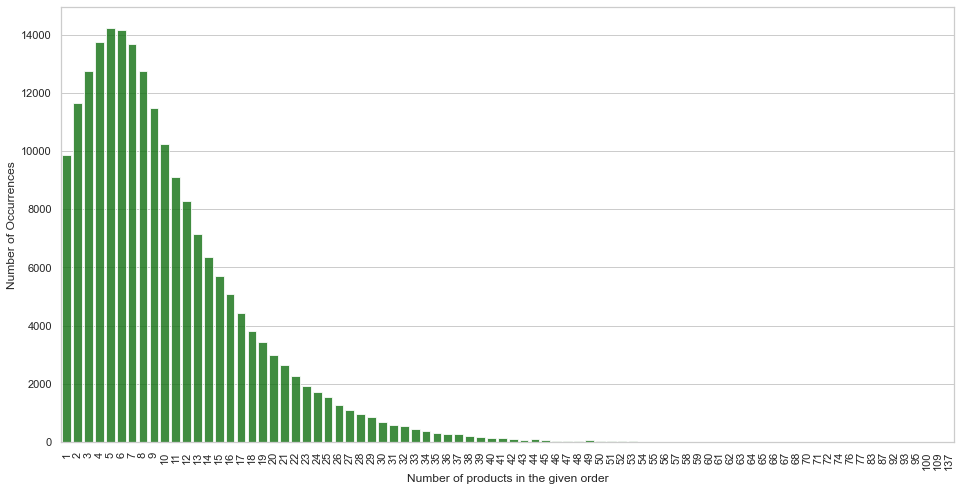

In [19]:
grouped_df = orderProducts.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
cnt_srs = grouped_df.add_to_cart_order.value_counts()

plt.figure(figsize=(16,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

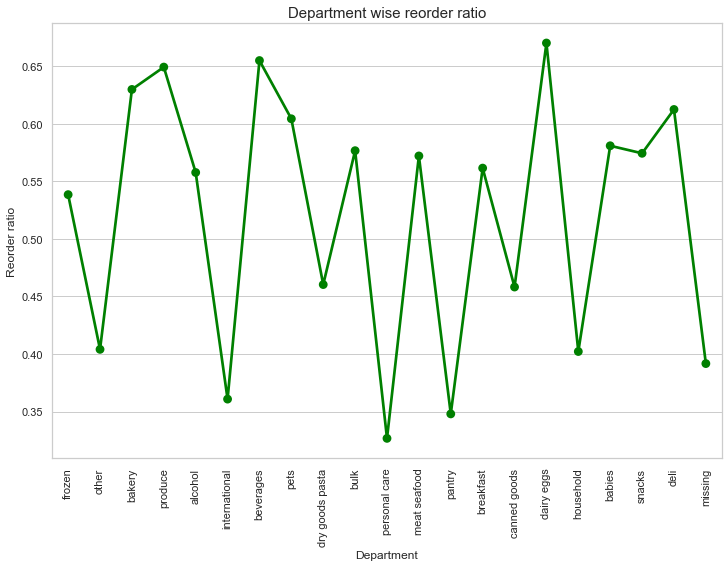

In [20]:
grouped_df = merge.groupby(["department_id"])["reordered"].aggregate("mean").reset_index()
grouped_df["department_id"] = grouped_df["department_id"].map({(i+1):dep for i,dep in enumerate(departments['department'].values)})

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['department_id'].values, grouped_df['reordered'].values, alpha=0.8, color='green')
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.title("Department wise reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')#
plt.show()

In [21]:
grouped_df.sort_values(by='reordered', ascending=False)

,department_id,reordered
15,dairy eggs,0.670193
6,beverages,0.654967
3,produce,0.649283
2,bakery,0.629859
19,deli,0.612449
7,pets,0.604357
17,babies,0.580918
9,bulk,0.576653
18,snacks,0.574370
11,meat seafood,0.572067


In [22]:
cnt_srs =  merge['product_name'].value_counts().reset_index().head(20)
cnt_srs.columns = ['product_name', 'frequency_count']
cnt_srs

,product_name,frequency_count
0,fresh fruits,226039
1,fresh vegetables,212611
2,packaged vegetables fruits,109596
3,yogurt,90751
4,packaged cheese,61502
5,milk,55150
6,water seltzer sparkling water,52564
7,chips pretzels,45306
8,soy lactosefree,39389
9,bread,36381


## 3. Data Preparation <a class="anchor" id="3"></a>

### Feature Engineering

##### New_Customer

In [23]:
orders.insert(4, 'New_Customer', 0)

for i in range (len(orders)):
    if np.isnan(orders['days_since_prior_order'][i]):
            orders['New_Customer'][i] = 1
    else:
            orders['New_Customer'][i] = 0
orders

,order_id,user_id,order_number,order_dow,New_Customer,order_hour_of_day,days_since_prior_order
0,2425083,49125,1,2,1,18,NaN
1,1944304,162867,1,3,1,17,NaN
2,1201011,147243,14,0,0,16,3.0
3,1906860,195275,81,1,0,11,3.0
4,2766469,58222,3,6,0,11,6.0
...,...,...,...,...,...,...,...
199995,2768632,137024,14,3,0,8,8.0
199996,1754449,190356,9,6,0,15,3.0
199997,792803,84264,5,3,0,13,21.0
199998,3390742,199430,16,3,0,18,5.0


#### Missing Values

In [24]:
orders['days_since_prior_order'].fillna(0,inplace=True)

# 4. Modeling and Evaluation <a class="anchor" id="4"></a>

## 4.1. Association Rules <a class="anchor" id="4.1"></a>

In [25]:
df_AR = pd.merge (orders, orderProducts, how='left', on='order_id')
df_AR

,order_id,user_id,order_number,order_dow,New_Customer,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2425083,49125,1,2,1,18,0.0,17,1,0
1,2425083,49125,1,2,1,18,0.0,91,2,0
2,2425083,49125,1,2,1,18,0.0,36,3,0
3,2425083,49125,1,2,1,18,0.0,83,4,0
4,2425083,49125,1,2,1,18,0.0,83,5,0
...,...,...,...,...,...,...,...,...,...,...
2019496,3390742,199430,16,3,0,18,5.0,83,8,0
2019497,458285,128787,42,2,0,19,3.0,115,1,1
2019498,458285,128787,42,2,0,19,3.0,32,2,1
2019499,458285,128787,42,2,0,19,3.0,32,3,1


In [26]:
df_AR = pd.merge(df_AR, products, how='left', on='product_id')

In [27]:
basket = (df_AR.groupby(['user_id', 'product_name'])['order_number'].count().unstack().reset_index().fillna(0).set_index('user_id'))

In [28]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)

In [29]:
frequent_itemsets = apriori(basket_sets, min_support=0.07, use_colnames=True)

If no threshold is defined, we have the following amount of rules

In [30]:
association_rules(frequent_itemsets, metric="lift", min_threshold=0).shape

(1590, 9)

##### Setting a threshold of 75% for the confidence

In [31]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.75)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(baking ingredients),(fresh fruits),0.124866,0.634759,0.094041,0.753138,1.186494,0.014781,1.479535
1,(bread),(fresh fruits),0.231427,0.634759,0.180578,0.780282,1.229256,0.033678,1.662313
2,(breakfast bakery),(fresh fruits),0.101356,0.634759,0.078653,0.776007,1.222523,0.014316,1.630594
3,(butter),(fresh fruits),0.120306,0.634759,0.094412,0.784761,1.236313,0.018046,1.696910
4,(canned jarred vegetables),(fresh fruits),0.116944,0.634759,0.092968,0.794980,1.252412,0.018737,1.781490
...,...,...,...,...,...,...,...,...,...
259,"(yogurt, fresh vegetables, packaged vegetables...",(fresh fruits),0.098458,0.634759,0.092721,0.941727,1.483597,0.030224,6.267751
260,"(yogurt, packaged vegetables fruits, fresh fru...",(fresh vegetables),0.106988,0.534468,0.092721,0.866643,1.621507,0.035539,3.490874
261,"(yogurt, fresh vegetables, fresh fruits, packa...",(packaged vegetables fruits),0.112992,0.467641,0.092721,0.820597,1.754757,0.039881,2.967388
262,"(yogurt, packaged vegetables fruits, packaged ...","(fresh vegetables, fresh fruits)",0.116203,0.424468,0.092721,0.797924,1.879821,0.043397,2.848093


In [32]:
rules.describe()

,antecedent support,consequent support,support,confidence,lift,leverage,conviction
count,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000
mean,0.123930,0.576305,0.102730,0.834727,1.463503,0.031090,2.871683
std,0.056091,0.067349,0.044545,0.054316,0.152147,0.011912,1.187227
min,0.076563,0.380430,0.070246,0.750453,1.186494,0.012240,1.479535
25%,0.093053,0.534468,0.076696,0.787264,1.364814,0.023126,2.203591
50%,0.107634,0.634759,0.090199,0.836539,1.445637,0.028850,2.538438
75%,0.134676,0.634759,0.107796,0.876639,1.563174,0.036562,3.085087
max,0.534468,0.634759,0.424468,0.959835,2.054159,0.094137,11.590565


##### Result 1 - 10 rules that had a higher confidence (assuming that the confidence and support were of at least 75% and 7%, respectively)

In [33]:
rules.sort_values(by=['confidence'], ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
201,"(fresh herbs, packaged vegetables fruits, fres...",(fresh vegetables),0.092236,0.534468,0.088532,0.959835,1.795872,0.039234,11.590565
255,"(yogurt, milk, fresh vegetables, packaged vege...",(fresh fruits),0.088665,0.634759,0.084267,0.950396,1.497255,0.027986,7.363192
144,"(fresh herbs, packaged vegetables fruits)",(fresh vegetables),0.101536,0.534468,0.096292,0.948358,1.774398,0.042025,9.014632
259,"(yogurt, fresh vegetables, packaged vegetables...",(fresh fruits),0.098458,0.634759,0.092721,0.941727,1.483597,0.030224,6.267751
251,"(milk, fresh vegetables, packaged vegetables f...",(fresh fruits),0.082709,0.634759,0.077712,0.939589,1.480229,0.025212,6.045917
88,"(fresh herbs, fresh fruits)",(fresh vegetables),0.121636,0.534468,0.114208,0.938930,1.756758,0.049197,7.622945
243,"(yogurt, packaged vegetables fruits, soy lacto...",(fresh fruits),0.076563,0.634759,0.071604,0.935236,1.473371,0.023005,5.639543
235,"(yogurt, fresh vegetables, soy lactosefree)",(fresh fruits),0.079954,0.634759,0.074397,0.930498,1.465907,0.023645,5.255098
240,"(yogurt, milk, packaged vegetables fruits)",(fresh fruits),0.107634,0.634759,0.099769,0.926926,1.460280,0.031447,4.998242
176,"(yogurt, packaged vegetables fruits, bread)",(fresh fruits),0.081749,0.634759,0.075689,0.925866,1.458609,0.023798,4.926744


##### Result 2 - 10 rules that have a higher lift (assuming that the confidence and support were of at least 75% and 7%, respectively)

In [34]:
rules.sort_values(by=['lift'], ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
204,"(fresh herbs, packaged vegetables fruits)","(fresh vegetables, fresh fruits)",0.101536,0.424468,0.088532,0.871924,2.054159,0.045433,4.493691
263,"(yogurt, fresh vegetables, packaged cheese)","(packaged vegetables fruits, fresh fruits)",0.123004,0.380430,0.092721,0.753803,1.981451,0.045926,2.516566
90,(fresh herbs),"(fresh vegetables, fresh fruits)",0.141907,0.424468,0.114208,0.804806,1.896036,0.053973,2.948517
262,"(yogurt, packaged vegetables fruits, packaged ...","(fresh vegetables, fresh fruits)",0.116203,0.424468,0.092721,0.797924,1.879821,0.043397,2.848093
254,"(milk, packaged vegetables fruits, packaged ch...","(fresh vegetables, fresh fruits)",0.098335,0.424468,0.077712,0.790282,1.861819,0.035972,2.744316
258,"(yogurt, milk, packaged vegetables fruits)","(fresh vegetables, fresh fruits)",0.107634,0.424468,0.084267,0.782896,1.844419,0.038579,2.650957
208,"(packaged vegetables fruits, frozen produce)","(fresh vegetables, fresh fruits)",0.127279,0.424468,0.097157,0.763341,1.798347,0.043131,2.431900
201,"(fresh herbs, packaged vegetables fruits, fres...",(fresh vegetables),0.092236,0.534468,0.088532,0.959835,1.795872,0.039234,11.590565
195,"(eggs, packaged vegetables fruits)","(fresh vegetables, fresh fruits)",0.126927,0.424468,0.096568,0.760814,1.792396,0.042691,2.406214
144,"(fresh herbs, packaged vegetables fruits)",(fresh vegetables),0.101536,0.534468,0.096292,0.948358,1.774398,0.042025,9.014632


#### Network of the top 50 confidence rules

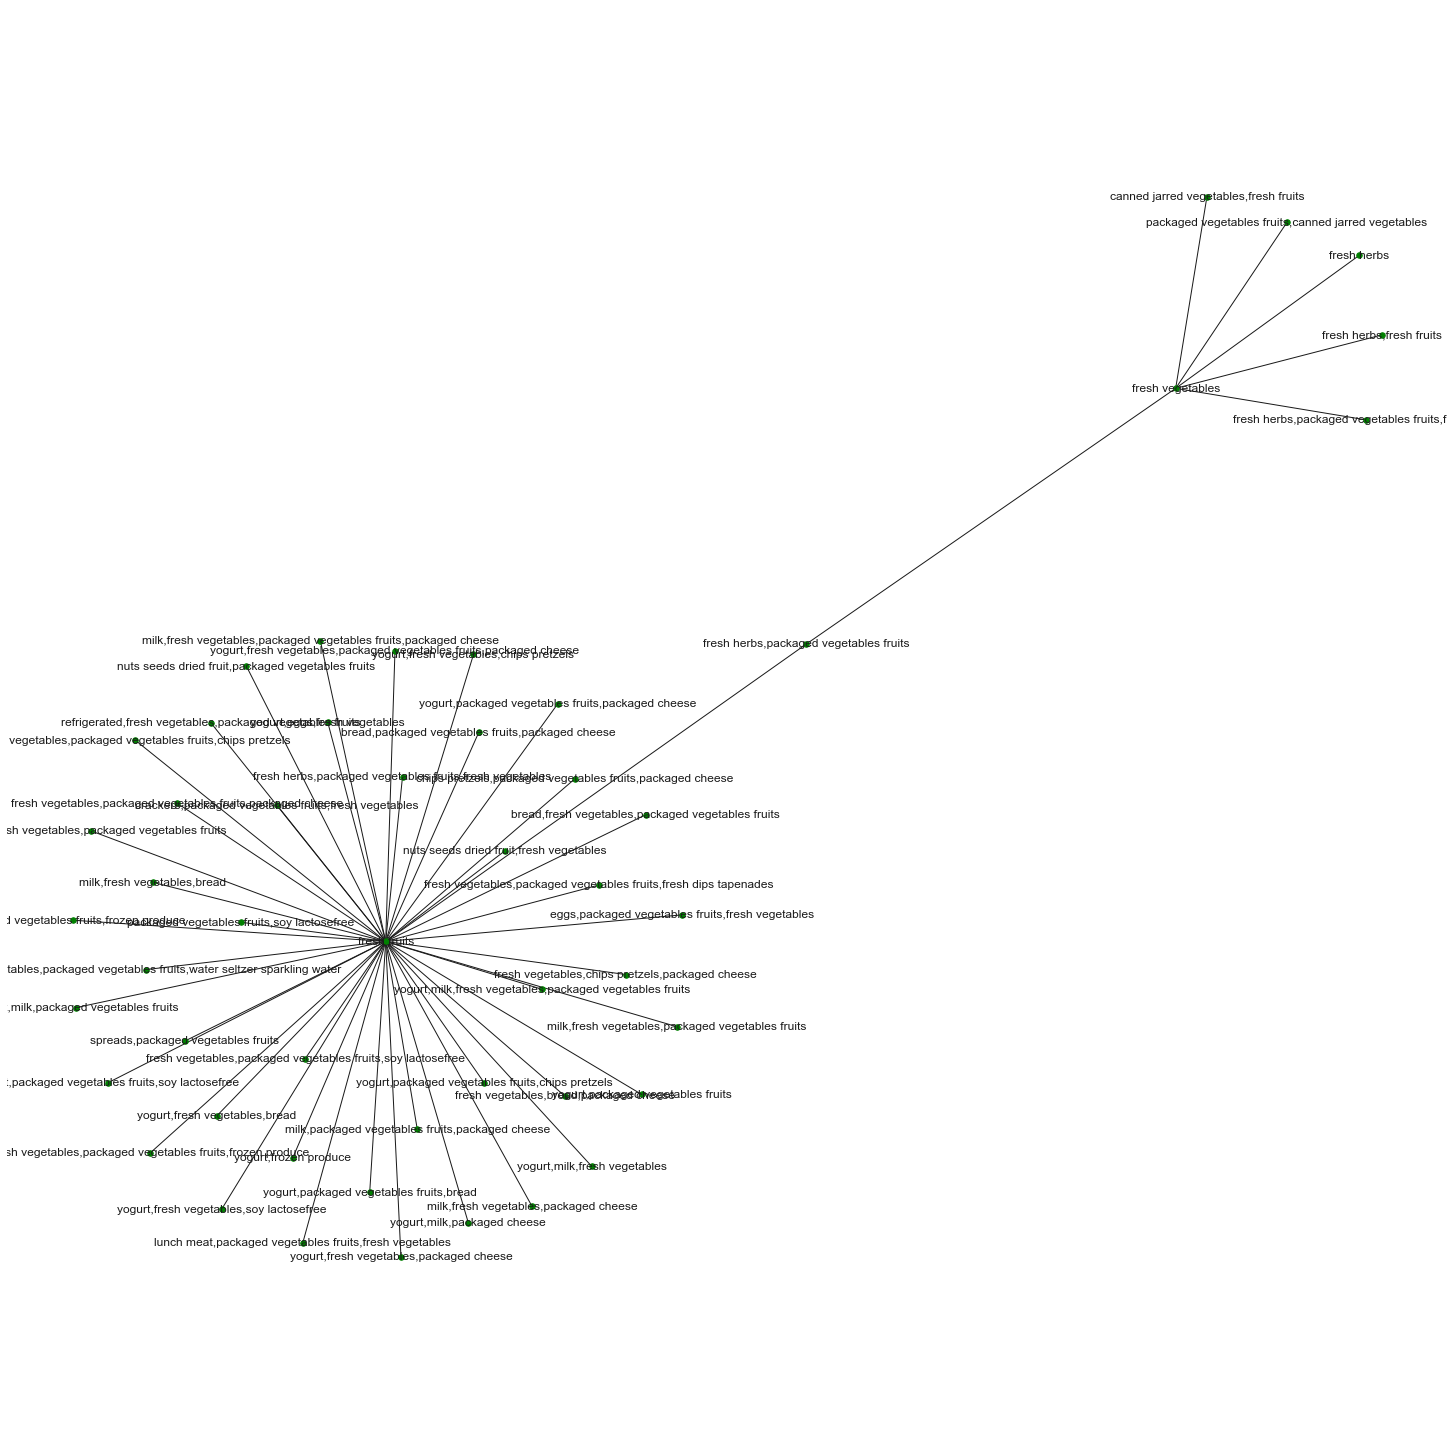

In [35]:
import networkx as nx
### Plot a basic network graph of the top 50 confidence rules
# Create a copy of the rules and transform the frozensets to strings
rulesToPlot = rules.sort_values(by=['confidence'], ascending=False).copy(deep=True)
rulesToPlot['LHS'] = [','.join(list(x)) for x in rulesToPlot['antecedents']]
rulesToPlot['RHS'] = [','.join(list(x)) for x in rulesToPlot['consequents']]
# Remove duplicate if reversed rules
rulesToPlot['sortedRow'] = [sorted([a,b]) for a,b in zip(rulesToPlot.LHS, rulesToPlot.RHS)]
rulesToPlot['sortedRow'] = rulesToPlot['sortedRow'].astype(str)
rulesToPlot.drop_duplicates(subset=['sortedRow'], inplace=True)
# Plot
rulesToPlot=rulesToPlot[:50]
fig = plt.figure(figsize=(20, 20)) 
G = nx.from_pandas_edgelist(rulesToPlot, 'LHS', 'RHS')  
# Each node is an itemset (either source or target) and the edges connect the itemsets if they consist of a high confidence rule
nx.draw(G, with_labels=True, node_size=30, node_color="green", pos=nx.spring_layout(G))
plt.axis('equal')
plt.show()

#### Next step -> Reducing the confidence threshold to 50%

In an attempt of finding unexpected rules, more complementary goods and substitute goods (there weren´t any with a confidence of 75% or higher)

In [36]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

##### Result 3 - independent items lift~1

In [37]:
rules[(rules['lift']>=0.95)&(rules['lift']<=1.05)].sort_values(by=['lift'], ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
93,(water seltzer sparkling water),(fresh vegetables),0.255555,0.534468,0.142449,0.55741,1.042926,0.005863,1.051837


##### Result 4 - substitute products

In [38]:
rules[(rules['lift']<=1)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
65,(soft drinks),(fresh fruits),0.125797,0.634759,0.073514,0.584384,0.920639,-0.006337,0.878794


##### Complementary products by setting a threshold of 1.5 for the lift and mantaining the confidence of at least 50%

In [39]:
rules[(rules['lift'] >= 1.5)].head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
12,(canned jarred vegetables),(fresh vegetables),0.116944,0.534468,0.099798,0.853383,1.596698,0.037295,3.175164
15,(canned meals beans),(fresh vegetables),0.111187,0.534468,0.091011,0.818539,1.531504,0.031585,2.565470
20,(cereal),(yogurt),0.140587,0.341788,0.072773,0.517635,1.514494,0.024722,1.364553
28,(crackers),(packaged cheese),0.172912,0.323435,0.088940,0.514366,1.590321,0.033014,1.393157
73,(fresh herbs),(fresh vegetables),0.141907,0.534468,0.129862,0.915121,1.712212,0.054018,5.484692
74,(fresh herbs),(packaged vegetables fruits),0.141907,0.467641,0.101536,0.715510,1.530040,0.035174,1.871272
91,(spices seasonings),(fresh vegetables),0.090935,0.534468,0.073428,0.807479,1.510811,0.024826,2.418091
99,(lunch meat),(packaged cheese),0.153325,0.323435,0.087677,0.571836,1.768007,0.038086,1.580152
106,(other creams cheeses),(packaged cheese),0.134355,0.323435,0.076344,0.568227,1.756849,0.032889,1.566945
116,"(fresh fruits, baking ingredients)",(fresh vegetables),0.094041,0.534468,0.076050,0.808687,1.513070,0.025788,2.433353


In [40]:
rules[(rules['lift'] >= 1.5)].iloc[70:74,:]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
254,(oils vinegars),"(fresh vegetables, fresh fruits)",0.113476,0.424468,0.073124,0.644400,1.518136,0.024957,1.618481
256,"(fresh fruits, other creams cheeses)",(fresh vegetables),0.103588,0.534468,0.083184,0.803026,1.502479,0.027819,2.363423
270,"(fresh fruits, soup broth bouillon)",(fresh vegetables),0.104680,0.534468,0.088883,0.849093,1.588670,0.032935,3.084887
271,(soup broth bouillon),"(fresh vegetables, fresh fruits)",0.135552,0.424468,0.088883,0.655711,1.544784,0.031346,1.671656


In [41]:
rules[(rules['lift'] >= 1.5)].iloc[[130],:]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
392,"(yogurt, packaged cheese)",(milk),0.158816,0.3042,0.085502,0.53837,1.769791,0.03719,1.507267


##### Viewing results for one antecedent lhs item against consequents 

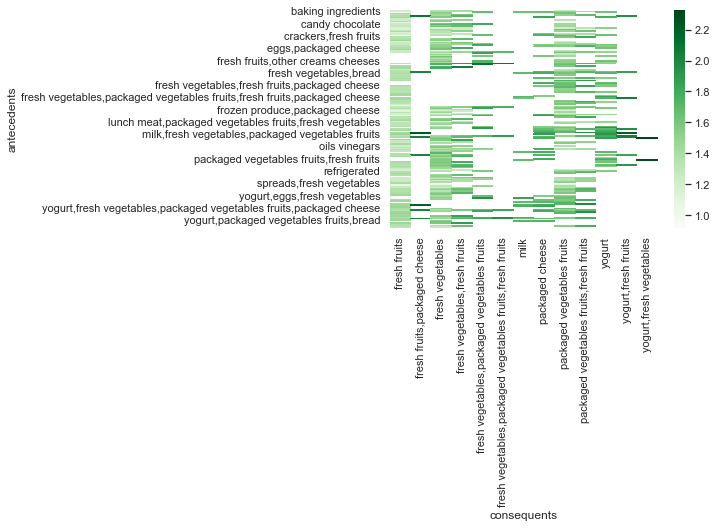

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Replacing the sets with strings
rules['antecedents'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents'] = rules['consequents'].apply(lambda a: ','.join(list(a)))

# Transforming the dataframe of rules into a matrix using the lift metric
pivot = rules.pivot(index = 'antecedents',columns = 'consequents', values= 'lift')

# Generating a heatmap
sns.heatmap(pivot, annot = False, cmap='Greens')
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

##### Even without setting a threshold for the confidence, there aren´t substitute goods other than the pair already seen

In [43]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0)

In [44]:
rules[(rules['lift'] < 1)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
162,(soft drinks),(fresh fruits),0.125797,0.634759,0.073514,0.584384,0.920639,-0.006337,0.878794
163,(fresh fruits),(soft drinks),0.634759,0.125797,0.073514,0.115813,0.920639,-0.006337,0.988709


### 4.2. Customers Segmentation by product <a class="anchor" id="4.2"></a>

In [45]:
df_Seg = pd.merge(df_AR, departments, how='left', on='department_id')
ProductCount = df_Seg.groupby(['user_id', 'product_name'])['product_name'].count().to_frame() 
ProductCount.columns=['count']
ProductCount

count
user_id product_name               
2       chips pretzels            1
        crackers                  1
        fresh dips tapenades      1
        fresh fruits              3
        lunch meat                1
...                             ...
206209  soft drinks               3
        soy lactosefree           2
        spices seasonings         1
        trash bags liners         1
        yogurt                    1

[1109568 rows x 1 columns]

In [46]:
table = pd.pivot_table(ProductCount, values='count', index=['user_id'],
                    columns=['product_name'])

In [47]:
table.fillna(0,inplace=True)

In [48]:
table.head()

product_name,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,dry pasta,eggs,energy granola bars,energy sports drinks,eye ear care,facial care,feminine care,first aid,food storage,fresh dips tapenades,fresh fruits,fresh herbs,fresh pasta,fresh vegetables,frozen appetizers sides,frozen breads doughs,frozen breakfast,frozen dessert,frozen juice,frozen meals,frozen meat seafood,frozen pizza,frozen produce,frozen vegan vegetarian,fruit vegetable snacks,grains rice dried goods,granola,hair care,honeys syrups nectars,hot cereal pancake mixes,hot dogs bacon sausage,ice cream ice,ice cream toppings,indian foods,instant foods,juice nectars,kitchen supplies,kosher foods,latino foods,laundry,lunch meat,marinades meat preparation,meat counter,milk,mint gum,missing,more household,muscles joints pain relief,nuts seeds dried fruit,oils vinegars,oral hygiene,other,other creams cheeses,packaged cheese,packaged meat,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [49]:
# Obtaining frequency and days_between_orders
customer_history = df_Seg[['user_id', 'days_since_prior_order']].groupby("user_id").min().reset_index()
customer_history.rename(columns={'days_since_prior_order':'days_between_orders'}, inplace=True)
customer_freq = (df_Seg[['user_id', 'order_id']].groupby(["user_id", 'order_id']).count().reset_index()).\
                groupby(["user_id"]).count().reset_index()
customer_freq.rename(columns={'order_id':'frequency'},inplace=True)
customer_history = customer_history.merge(customer_freq)

In [50]:
df = pd.merge(table, customer_history, how='inner', on='user_id')

In [51]:
features = df.columns
features = np.delete(features, 0)
features

Index(['air fresheners candles', 'asian foods', 'baby accessories',
       'baby bath body care', 'baby food formula', 'bakery desserts',
       'baking ingredients', 'baking supplies decor', 'beauty',
       'beers coolers',
       ...
       'tofu meat alternatives', 'tortillas flat bread', 'trail mix snack mix',
       'trash bags liners', 'vitamins supplements',
       'water seltzer sparkling water', 'white wines', 'yogurt',
       'days_between_orders', 'frequency'],
      dtype='object', length=136)

##### Scaling the metric features using the min max scaler

In [52]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df[features])
scaler.transform(df[features])

array([[0.        , 0.        , 0.        , ..., 0.        , 0.1       ,
        0.07142857],
       [0.        , 0.        , 0.        , ..., 0.        , 0.3       ,
        0.14285714],
       [0.        , 0.        , 0.        , ..., 0.00714286, 1.        ,
        0.        ],
       ...,
       [0.        , 0.06666667, 0.        , ..., 0.        , 0.        ,
        0.21428571],
       [0.        , 0.        , 0.        , ..., 0.00714286, 0.16666667,
        0.07142857],
       [0.        , 0.        , 0.        , ..., 0.00714286, 0.1       ,
        0.14285714]])

##### PCA to reduce the dimensionality as we have a lot of product variables

In [53]:
#PCA
from sklearn.decomposition import PCA
pca = PCA()
pca_feat = pca.fit_transform(df[features])
# pca_feat  

In [54]:
# Output PCA table
pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)
)

,Eigenvalue,Difference,Proportion,Cumulative
1,96.980081,0.000000,0.619986,0.619986
2,19.430916,-77.549165,0.124220,0.744206
3,5.782546,-13.648370,0.036967,0.781174
4,3.628608,-2.153938,0.023197,0.804371
5,2.259851,-1.368758,0.014447,0.818818
...,...,...,...,...
132,0.006251,-0.000447,0.000040,0.999868
133,0.006231,-0.000020,0.000040,0.999908
134,0.005987,-0.000243,0.000038,0.999947
135,0.004674,-0.001313,0.000030,0.999976


In [55]:
pca = PCA(n_components=5)
pca_feat = pca.fit_transform(df[features])
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_feat, index=df.index, columns=pca_feat_names)
pca_df

,PC0,PC1,PC2,PC3,PC4
0,6.674412,-2.213671,0.977490,-1.691812,0.368576
1,0.950672,-0.269998,1.511522,-1.809491,-1.286649
2,-20.074227,1.423211,1.168039,0.733518,-1.247903
3,-3.909086,2.086995,-0.851143,0.622092,-0.434931
4,-20.319072,-0.319532,0.366440,-0.065357,-1.258284
...,...,...,...,...,...
105268,-1.265757,-0.845544,-0.944178,0.066353,-0.327995
105269,-0.425397,-2.089008,-0.504570,-0.356313,0.495979
105270,9.606638,-3.411474,-0.474021,0.514419,-1.435392
105271,5.256375,2.085776,1.642099,-2.264365,0.922638


#### Clusters

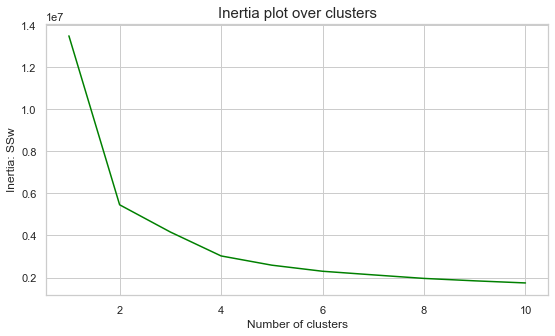

In [56]:
# Defining the number of clusters:
range_clusters = range(1, 11)
inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(pca_df) 
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution
    
# The figure:
plt.figure(figsize=(9,5))
#This following step is to make sure that we plot the correct x axis'labels:
plot_df=pd.DataFrame(columns=['x','y'])
plot_df['x']=range(1, 11)
plot_df['y']=inertia

# The inertia plot:
plt.plot('x', 'y',data = plot_df,color='green')
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

# By looking at the plot we conclude that the best number of clusters would be 3

In [57]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst


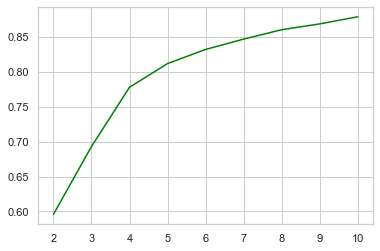

In [58]:
r2_list_kmeans=[]
for i in range(2,11):
    number_clusters = i
    kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=1)
    km_labels = kmclust.fit_predict(pca_df)# Characterizing the final clusters
    df_concat_kmeans = pd.concat((pca_df, pd.Series(km_labels, name='labels')), axis=1)
    r2_list_kmeans.append(r2(df_concat_kmeans,'labels'))

plt.plot(pd.DataFrame(r2_list_kmeans, index=range(2,11), columns=['R2']), color = 'green')
plt.show()

##### Kmeans

In [59]:
number_clusters = 4
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=1)
km_labels = kmclust.fit_predict(pca_df)# Characterizing the final clusters
df_concat_kmeans = pd.concat((pca_df, pd.Series(km_labels, name='labels')), axis=1)

In [60]:
df.insert(0, 'labels', df_concat_kmeans['labels'])

In [61]:
df.drop(columns=['user_id']).groupby('labels').mean()

,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,dry pasta,eggs,energy granola bars,energy sports drinks,eye ear care,facial care,feminine care,first aid,food storage,fresh dips tapenades,fresh fruits,fresh herbs,fresh pasta,fresh vegetables,frozen appetizers sides,frozen breads doughs,frozen breakfast,frozen dessert,frozen juice,frozen meals,frozen meat seafood,frozen pizza,frozen produce,frozen vegan vegetarian,fruit vegetable snacks,grains rice dried goods,granola,hair care,honeys syrups nectars,hot cereal pancake mixes,hot dogs bacon sausage,ice cream ice,ice cream toppings,indian foods,instant foods,juice nectars,kitchen supplies,kosher foods,latino foods,laundry,lunch meat,marinades meat preparation,meat counter,milk,mint gum,missing,more household,muscles joints pain relief,nuts seeds dried fruit,oils vinegars,oral hygiene,other,other creams cheeses,packaged cheese,packaged meat,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,days_between_orders,frequency
labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.013946,0.085734,0.004263,0.004796,0.173269,0.022159,0.172736,0.013615,0.004042,0.038678,0.025834,0.299114,0.137072,0.044962,0.009444,0.007570,0.061793,0.126764,0.184588,0.043418,0.134059,0.121693,0.036693,0.039174,0.207041,0.395432,0.073074,0.014185,0.125276,0.017639,0.120737,0.143962,0.240684,0.183081,0.009095,0.015875,0.015526,0.052936,0.022049,0.057585,0.123493,0.224313,0.244175,0.071255,0.006174,0.009316,0.013248,0.007662,0.041599,0.174721,1.589023,0.158809,0.018999,1.321237,0.102712,0.019183,0.117393,0.011539,0.002554,0.221520,0.037153,0.086561,0.248383,0.049904,0.089391,0.064861,0.052275,0.019109,0.036859,0.078513,0.156549,0.292794,0.006927,0.007497,0.105248,0.187197,0.005659,0.006339,0.036436,0.054351,0.198074,0.033753,0.035058,0.466173,0.016096,0.043400,0.012899,0.012844,0.160720,0.122666,0.039982,0.021130,0.157412,0.482030,0.016445,0.063704,0.178120,0.009940,0.800989,0.149034,0.108151,0.056960,0.029932,0.096189,0.060653,0.053947,0.039211,0.056905,0.021075,0.026551,0.315412,0.022380,0.052091,0.013193,0.006596,0.005861,0.032706,0.238534,0.172736,0.322927,0.040772,0.008121,0.111054,0.023152,0.153315,0.150632,0.056335,0.093488,0.023354,0.019422,0.026992,0.501378,0.024015,0.697229,3.499945,1.952576
1,0.008504,0.063623,0.002073,0.002232,0.088338,0.010949,0.114649,0.009780,0.002232,0.014829,0.020517,0.191187,0.077761,0.028330,0.004252,0.005687,0.040555,0.090890,0.086159,0.029659,0.109706,0.106410,0.025300,0.024716,0.141862,0.260604,0.054746,0.008611,0.068460,0.009408,0.081748,0.077070,0.160997,0.091528,0.007494,0.007229,0.010311,0.032263,0.012119,0.044754,0.102955,0.166153,0.137185,0.037047,0.005156,0.006591,0.008026,0.004837,0.0275

Text(0.5, 1.0, '4 Clusters')

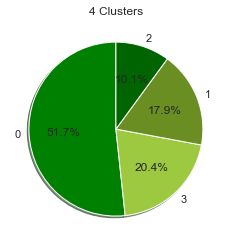

In [62]:
market = df.labels.value_counts()
color = ["#008000","#9cc93f","#6b8e23","#006400"]
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90, colors=color)
plt.title('4 Clusters')

##### New customer and clusters

In [63]:
df_analysis = pd.merge(df, orders.groupby('user_id')['New_Customer'].min(), how='inner', on='user_id')
df_analysis.drop(columns=['user_id']).groupby('labels').mean()

,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,dry pasta,eggs,energy granola bars,energy sports drinks,eye ear care,facial care,feminine care,first aid,food storage,fresh dips tapenades,fresh fruits,fresh herbs,fresh pasta,fresh vegetables,frozen appetizers sides,frozen breads doughs,frozen breakfast,frozen dessert,frozen juice,frozen meals,frozen meat seafood,frozen pizza,frozen produce,frozen vegan vegetarian,fruit vegetable snacks,grains rice dried goods,granola,hair care,honeys syrups nectars,hot cereal pancake mixes,hot dogs bacon sausage,ice cream ice,ice cream toppings,indian foods,instant foods,juice nectars,kitchen supplies,kosher foods,latino foods,laundry,lunch meat,marinades meat preparation,meat counter,milk,mint gum,missing,more household,muscles joints pain relief,nuts seeds dried fruit,oils vinegars,oral hygiene,other,other creams cheeses,packaged cheese,packaged meat,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,days_between_orders,frequency,New_Customer
labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.013946,0.085734,0.004263,0.004796,0.173269,0.022159,0.172736,0.013615,0.004042,0.038678,0.025834,0.299114,0.137072,0.044962,0.009444,0.007570,0.061793,0.126764,0.184588,0.043418,0.134059,0.121693,0.036693,0.039174,0.207041,0.395432,0.073074,0.014185,0.125276,0.017639,0.120737,0.143962,0.240684,0.183081,0.009095,0.015875,0.015526,0.052936,0.022049,0.057585,0.123493,0.224313,0.244175,0.071255,0.006174,0.009316,0.013248,0.007662,0.041599,0.174721,1.589023,0.158809,0.018999,1.321237,0.102712,0.019183,0.117393,0.011539,0.002554,0.221520,0.037153,0.086561,0.248383,0.049904,0.089391,0.064861,0.052275,0.019109,0.036859,0.078513,0.156549,0.292794,0.006927,0.007497,0.105248,0.187197,0.005659,0.006339,0.036436,0.054351,0.198074,0.033753,0.035058,0.466173,0.016096,0.043400,0.012899,0.012844,0.160720,0.122666,0.039982,0.021130,0.157412,0.482030,0.016445,0.063704,0.178120,0.009940,0.800989,0.149034,0.108151,0.056960,0.029932,0.096189,0.060653,0.053947,0.039211,0.056905,0.021075,0.026551,0.315412,0.022380,0.052091,0.013193,0.006596,0.005861,0.032706,0.238534,0.172736,0.322927,0.040772,0.008121,0.111054,0.023152,0.153315,0.150632,0.056335,0.093488,0.023354,0.019422,0.026992,0.501378,0.024015,0.697229,3.499945,1.952576,0.116162
1,0.008504,0.063623,0.002073,0.002232,0.088338,0.010949,0.114649,0.009780,0.002232,0.014829,0.020517,0.191187,0.077761,0.028330,0.004252,0.005687,0.040555,0.090890,0.086159,0.029659,0.109706,0.106410,0.025300,0.024716,0.141862,0.260604,0.054746,0.008611,0.068460,0.009408,0.081748,0.077070,0.160997,0.091528,0.007494,0.007229,0.010311,0.032263,0.012119,0.044754,0.102955,0.166153,0.137185,0.037047,0.005156,0.006591,0

###### Day of the week and clusters

In [64]:
aux = df_Seg.groupby(['user_id', 'order_dow'])[['order_dow']].count().rename(columns={'order_dow':'count'})
aux=pd.pivot_table(aux, values='count', index=['user_id'],
                    columns=['order_dow']).fillna(0).rename(columns={i:'order_dow-'+str(i) for i in range(7)})
aux = pd.merge(aux,df_analysis,on='user_id').drop(columns=['user_id']).groupby('labels').sum().iloc[:,:7]

In [65]:
# Percentage of customers in each cluster that purchase in each dow 
aux.div(aux.sum(axis=1), axis=0)*100

,order_dow-0,order_dow-1,order_dow-2,order_dow-3,order_dow-4,order_dow-5,order_dow-6
labels,,,,,,,
0,18.058762,17.389460,12.975853,12.226653,12.098119,13.543028,13.708125
1,21.381633,17.038534,13.552701,12.081108,10.228508,11.725117,13.992399
2,20.530487,17.305561,12.547162,11.036394,11.395087,12.918469,14.266839
3,19.621066,17.155042,13.451198,12.111400,11.723058,12.305400,13.632836


###### Order hour of day and clusters

In [66]:
aux2 = df_Seg.groupby(['user_id', 'order_hour_of_day'])[['order_hour_of_day']].count().rename(columns={'order_hour_of_day':'count'})
aux2=pd.pivot_table(aux2, values='count', index=['user_id'],
                    columns=['order_hour_of_day']).fillna(0).rename(columns={i:'order_hour_of_day-'+str(i) for i in range(24)})
aux2 = pd.merge(aux2,df_analysis,on='user_id').drop(columns=['user_id']).groupby('labels').sum().iloc[:,:24]

# Percentage of customers in each cluster that purchase in hour of the day
aux2=aux2.div(aux2.sum(axis=1), axis=0)*100
aux2.style.applymap(lambda x: 'background-color : yellow' if x>5 else '')

,order_hour_of_day-0,order_hour_of_day-1,order_hour_of_day-2,order_hour_of_day-3,order_hour_of_day-4,order_hour_of_day-5,order_hour_of_day-6,order_hour_of_day-7,order_hour_of_day-8,order_hour_of_day-9,order_hour_of_day-10,order_hour_of_day-11,order_hour_of_day-12,order_hour_of_day-13,order_hour_of_day-14,order_hour_of_day-15,order_hour_of_day-16,order_hour_of_day-17,order_hour_of_day-18,order_hour_of_day-19,order_hour_of_day-20,order_hour_of_day-21,order_hour_of_day-22,order_hour_of_day-23
labels,,,,,,,,,,,,,,,,,,,,,,,,
0,0.670770,0.348475,0.211590,0.165887,0.168934,0.256278,0.876831,2.536715,5.096339,7.565909,8.674643,8.433825,8.022380,8.213883,8.229118,8.318719,7.941355,6.643939,5.341671,4.041998,3.076017,2.184403,1.816405,1.163917
1,0.659547,0.516669,0.198201,0.111608,0.204936,0.332419,0.876028,2.140280,4.401790,6.288546,8.059364,8.490403,8.520229,8.640015,8.674652,8.497619,8.104585,7.037090,5.840670,4.164141,2.777698,2.313946,2.015202,1.134363
2,0.625151,0.263620,0.192827,0.109106,0.135909,0.289792,1.068038,3.208687,6.059311,7.878634,8.741389,8.412495,8.017854,8.120338,8.329878,8.116869,7.508904,5.722376,4.149015,3.387797,3.121654,2.845264,2.391340,1.303751
3,0.755739,0.497531,0.240353,0.206017,0.166187,0.320013,0.662002,2.356835,4.811185,6.922517,8.323433,8.429532,8.191582,8.283946,8.256134,8.342318,8.035696,6.725084,5.708390,4.310907,3.186054,2.281296,1.823251,1.163996


###### Association Rules per cluster

In [67]:
basket_0 = df.loc[df['labels']==0]
basket_0.drop(['user_id','labels', 'frequency', 'days_between_orders'], axis='columns', inplace=True)
basket_1 = df.loc[df['labels']==1]
basket_1.drop(['user_id','labels', 'frequency', 'days_between_orders'],axis='columns', inplace=True)
basket_2 = df.loc[df['labels']==2]
basket_2.drop(['user_id','labels', 'frequency', 'days_between_orders'],axis='columns', inplace=True)
basket_3 = df.loc[df['labels']==3]
basket_3.drop(['user_id','labels', 'frequency', 'days_between_orders'], axis='columns', inplace=True)

Cluster 0

In [68]:
basket_sets_0 = basket_0.applymap(encode_units)

In [69]:
frequent_itemsets_0 = apriori(basket_sets_0, min_support=0.07, use_colnames=True)

In [70]:
rules_0 = association_rules(frequent_itemsets_0, metric="lift", min_threshold=0)
rules_0

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(fresh fruits),(baking ingredients),0.626396,0.117503,0.081968,0.130856,1.113634,0.008364,1.015363
1,(baking ingredients),(fresh fruits),0.117503,0.626396,0.081968,0.697576,1.113634,0.008364,1.235364
2,(fresh vegetables),(baking ingredients),0.505071,0.117503,0.075647,0.149774,1.274640,0.016299,1.037956
3,(baking ingredients),(fresh vegetables),0.117503,0.505071,0.075647,0.643784,1.274640,0.016299,1.389407
4,(bread),(chips pretzels),0.216375,0.234860,0.071494,0.330418,1.406874,0.020676,1.142713
...,...,...,...,...,...,...,...,...,...
635,"(fresh fruits, packaged cheese)","(yogurt, packaged vegetables fruits)",0.220399,0.177458,0.073332,0.332722,1.874929,0.034220,1.232682
636,(yogurt),"(packaged vegetables fruits, fresh fruits, pac...",0.318683,0.140471,0.073332,0.230108,1.638119,0.028566,1.116428
637,(packaged vegetables fruits),"(yogurt, fresh fruits, packaged cheese)",0.440100,0.107802,0.073332,0.166625,1.545661,0.025888,1.070584
638,(fresh fruits),"(yogurt, packaged vegetables fruits, packaged ...",0.626396,0.084062,0.073332,0.117069,1.392648,0.020675,1.037383


Cluster 1

In [71]:
basket_sets_1 = basket_1.applymap(encode_units)

In [72]:
frequent_itemsets_1 = apriori(basket_sets_1, min_support=0.07, use_colnames=True)

In [73]:
rules_1 = association_rules(frequent_itemsets_1, metric="lift", min_threshold=0)
rules_1

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(bread),(fresh fruits),0.168385,0.512225,0.111938,0.664773,1.297814,0.025687,1.455058
1,(fresh fruits),(bread),0.512225,0.168385,0.111938,0.218533,1.297814,0.025687,1.064171
2,(fresh vegetables),(bread),0.446210,0.168385,0.096524,0.216319,1.284669,0.021389,1.061165
3,(bread),(fresh vegetables),0.168385,0.446210,0.096524,0.573232,1.284669,0.021389,1.297637
4,(bread),(packaged vegetables fruits),0.168385,0.358084,0.079622,0.472854,1.320509,0.019325,1.217718
...,...,...,...,...,...,...,...,...,...
197,"(packaged vegetables fruits, fresh fruits)","(yogurt, fresh vegetables)",0.256192,0.154353,0.083023,0.324066,2.099513,0.043479,1.251080
198,(yogurt),"(fresh vegetables, packaged vegetables fruits,...",0.255129,0.188902,0.083023,0.325417,1.722676,0.034829,1.202369
199,(fresh vegetables),"(yogurt, packaged vegetables fruits, fresh fru...",0.446210,0.106995,0.083023,0.186063,1.738992,0.035281,1.097143
200,(packaged vegetables fruits),"(yogurt, fresh vegetables, fresh fruits)",0.358084,0.125651,0.083023,0.231854,1.845220,0.038030,1.138259


Cluster 2

In [74]:
basket_sets_2 = basket_2.applymap(encode_units)

In [75]:
frequent_itemsets_2 = apriori(basket_sets_2, min_support=0.12, use_colnames=True)

In [76]:
rules_2 = association_rules(frequent_itemsets_2, metric="lift", min_threshold=0)
rules_2

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(fresh fruits),(asian foods),0.994240,0.189330,0.187913,0.189002,0.998269,-0.000326,0.999596
1,(asian foods),(fresh fruits),0.189330,0.994240,0.187913,0.992519,0.998269,-0.000326,0.769940
2,(fresh vegetables),(asian foods),0.957507,0.189330,0.184797,0.192998,1.019376,0.003513,1.004546
3,(asian foods),(fresh vegetables),0.189330,0.957507,0.184797,0.976060,1.019376,0.003513,1.774965
4,(asian foods),(packaged cheese),0.189330,0.658451,0.129745,0.685287,1.040755,0.005081,1.085269
...,...,...,...,...,...,...,...,...,...
83883,(packaged cheese),"(milk, water seltzer sparkling water, yogurt, ...",0.658451,0.170444,0.135505,0.205794,1.207399,0.023276,1.044510
83884,(yogurt),"(milk, water seltzer sparkling water, packaged...",0.708026,0.162323,0.135505,0.191384,1.179035,0.020576,1.035940
83885,(packaged vegetables fruits),"(milk, water seltzer sparkling water, packaged...",0.917375,0.142210,0.135505,0.147710,1.038676,0.005046,1.006453
83886,(fresh vegetables),"(milk, water seltzer sparkling water, packaged...",0.957507,0.142115,0.135505,0.141519,0.995803,-0.000571,0.999305


Cluster 3

In [77]:
basket_sets_3 = basket_3.applymap(encode_units)

In [78]:
frequent_itemsets_3 = apriori(basket_sets_3, min_support=0.07, use_colnames=True)

In [79]:
rules_3 = association_rules(frequent_itemsets_3, metric="lift", min_threshold=0)
rules_3

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(bread),(fresh fruits),0.200140,0.585964,0.140919,0.704101,1.201611,0.023644,1.399246
1,(fresh fruits),(bread),0.585964,0.200140,0.140919,0.240490,1.201611,0.023644,1.053127
2,(fresh vegetables),(bread),0.477594,0.200140,0.119935,0.251123,1.254736,0.024349,1.068079
3,(bread),(fresh vegetables),0.200140,0.477594,0.119935,0.599254,1.254736,0.024349,1.303586
4,(milk),(bread),0.265423,0.200140,0.077780,0.293043,1.464190,0.024659,1.131412
...,...,...,...,...,...,...,...,...,...
409,"(packaged vegetables fruits, fresh fruits)","(yogurt, fresh vegetables)",0.313733,0.177804,0.104593,0.333383,1.875005,0.048810,1.233386
410,(yogurt),"(fresh vegetables, packaged vegetables fruits,...",0.295593,0.228678,0.104593,0.353841,1.547334,0.036997,1.193704
411,(fresh vegetables),"(yogurt, packaged vegetables fruits, fresh fru...",0.477594,0.136302,0.104593,0.219000,1.606726,0.039496,1.105887
412,(packaged vegetables fruits),"(yogurt, fresh vegetables, fresh fruits)",0.411564,0.150385,0.104593,0.254136,1.689903,0.042700,1.139101


###### Frequency of Day of week Vs Hour of Day By product and Segment 

In [80]:
def HeatMapProduct(name):
    Orders_Info = pd.merge(orders, orderProducts, how='left', on='order_id')
    Orders_Info = pd.merge(Orders_Info, products, how='left', on = 'product_id')
    Orders_Info = Orders_Info.loc[Orders_Info['product_name']==name]
    grouped_df = Orders_Info.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
    grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')
    plt.figure(figsize=(12,6))
    sns.heatmap(grouped_df, cmap="Greens")
    plt.title("Frequency of Day of week Vs Hour of day")
    plt.show() 

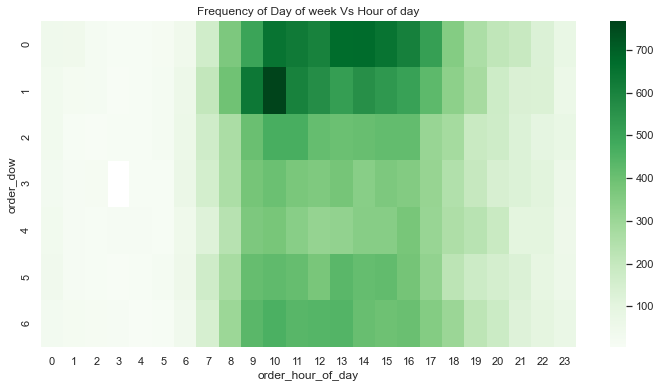

In [81]:
HeatMapProduct('soy lactosefree')

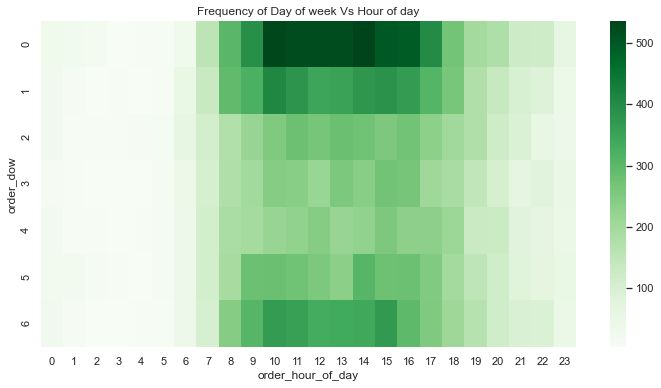

In [82]:
HeatMapProduct('eggs')

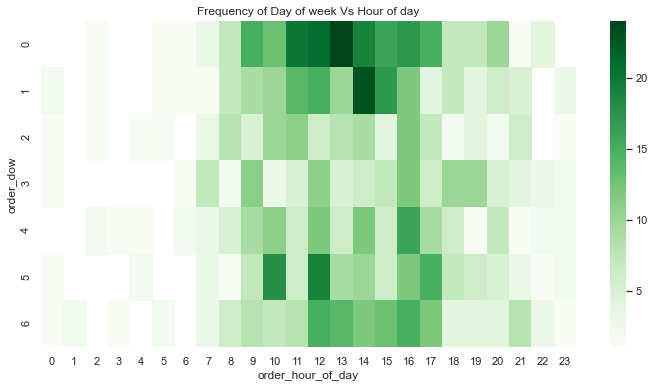

In [83]:
HeatMapProduct('indian foods')

In [84]:
def HeatMapDepartment(n):
    Orders_Info = pd.merge(orders, orderProducts, how='left', on='order_id')
    Orders_Info = pd.merge(Orders_Info, products, how='left', on = 'product_id')
    Orders_Info = Orders_Info.loc[Orders_Info['department_id']== n]
    grouped_df = Orders_Info.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
    grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')
    plt.figure(figsize=(12,6))
    sns.heatmap(grouped_df, cmap='Greens')
    plt.title("Frequency of Day of week Vs Hour of day")
    plt.show()

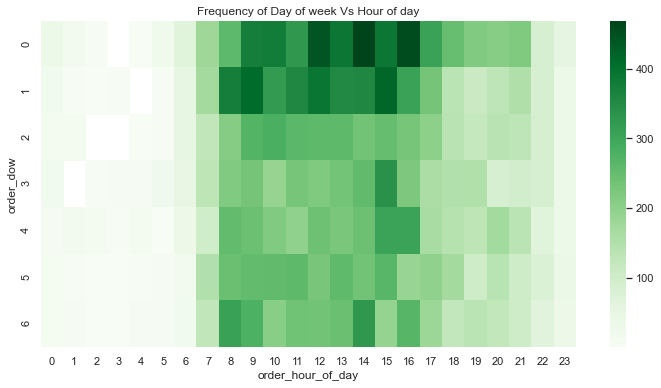

In [85]:
HeatMapDepartment(18)

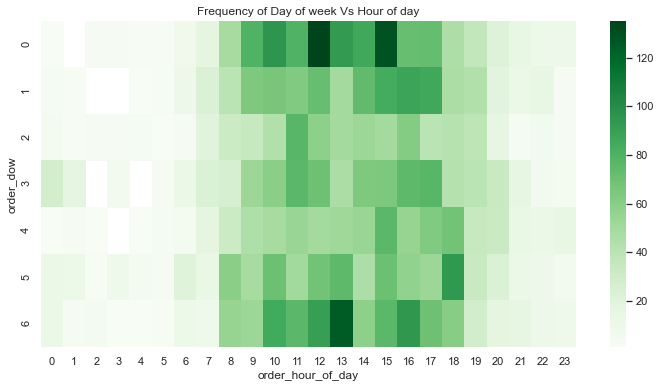

In [86]:
HeatMapDepartment(8)

# 5. Deployment <a class="anchor" id="5"></a>

##### Recommender system

In [87]:
df_AR = pd.merge(orders, orderProducts, how='left', on='order_id')
df_AR = pd.merge(df_AR, products, how='left', on='product_id')
basket = (df_AR.groupby(['user_id', 'product_name'])['order_number'].count().unstack().reset_index().fillna(0).set_index('user_id'))
basket_sets = basket.applymap(encode_units)
frequent_itemsets = apriori(basket_sets, min_support=0.07, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.75)
rules = rules[(rules['lift']>1)]
rules["antecedents"] = rules["antecedents"].apply(lambda x: [i.replace('(','') for i in x])
rules["antecedents"] = rules["antecedents"].apply(lambda x: [i.replace(')','') for i in x])
rules["antecedents"] = rules["antecedents"].astype(str)
rules["antecedents"] = rules["antecedents"].str.strip("[]")
rules["consequents"] = rules["consequents"].apply(lambda x: [i.replace('(','') for i in x])
rules["consequents"] = rules["consequents"].apply(lambda x: [i.replace(')','') for i in x])
rules["consequents"] = rules["consequents"].astype(str)
rules["consequents"] = rules["consequents"].str.strip("[]")
rules.sort_values(by=['confidence'], ascending=False, inplace=True)

In [88]:
def recommender_system(prod):
    y = rules.loc[rules["antecedents"]==("'"+ prod + "'")]
    return print("Recommended product:", y["consequents"].values[0])

In [89]:
recommender_system("fresh vegetables")

Recommended product: 'fresh fruits'
